# 1. TP sur Apache Spark :   
 **Réalisé par :**   MAHMAHI Anis (AMSD)



# 2. Préparation de l’environnement de travail

In [1]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
! wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

In [3]:
! tar xf /content/spark-3.5.0-bin-hadoop3.tgz

In [4]:
! pip install -q findspark
! pip install pyspark

In [5]:
# Configurer les variables d'environnement requises
import os
import re
# Définir le chemin vers JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Définir le chemin vers SPARK_HOME
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# Définir les arguments de soumission PySpark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.5 pyspark-shell'

# Importer le module findspark pour initialiser Spark dans un environnement Python
import findspark

findspark.init("spark-3.5.0-bin-hadoop3")

# Importer les modules Spark nécessaires
from pyspark import SparkContext, SparkConf

# Configurer Spark avec le nom de l'application et le mode maître local
configuration = SparkConf().setAppName("name").setMaster("local[4]")

# Initialiser le contexte Spark
sc = SparkContext(conf=configuration)


In [6]:
sc

<SparkContext master=local[4] appName=name>

***Création d'une session Spark***

In [7]:
from pyspark.sql import SparkSession

# Création d'une session Spark
spark = SparkSession.builder \
    .appName("TP2_Spark") \
    .getOrCreate()


In [8]:
spark

# 3. Données

In [9]:
# Téléchargement et extraction des données
!wget -O 20news-19997.tar.gz http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz
!tar -xzf 20news-19997.tar.gz

--2024-02-05 12:49:08--  http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz
Resolving qwone.com (qwone.com)... 173.48.205.131
Connecting to qwone.com (qwone.com)|173.48.205.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17332201 (17M) [application/x-gzip]
Saving to: ‘20news-19997.tar.gz’

20news-19997.tar.gz 100%[===================>]  16.53M  11.2MB/s    in 1.5s    

2024-02-05 12:49:09 (11.2 MB/s) - ‘20news-19997.tar.gz’ saved [17332201/17332201]



In [10]:
# Chargement des données dans les  deux RDD
alt_atheism_rdd = sc.wholeTextFiles("20_newsgroups/alt.atheism/*")
rec_sport_baseball_rdd = sc.wholeTextFiles("20_newsgroups/rec.sport.baseball/*")

print("Nombre de documents du 1er RDD:", alt_atheism_rdd.count())
print("Nombre de documents du 2eme RDD:", rec_sport_baseball_rdd.count())

Nombre de documents du 1er RDD: 1000
Nombre de documents du 2eme RDD: 1000


In [11]:
def separate_header_body(text):
    header, body = text.split("\n\n", 1)  # Séparation dès trouver "\n\n"
    return header, body

# Appliquer la fonction de séparation sur chaque RDD
alt_atheism_header_body_rdd = alt_atheism_rdd.map(lambda x: separate_header_body(x[1]))
rec_sport_baseball_header_body_rdd = rec_sport_baseball_rdd.map(lambda x: separate_header_body(x[1]))

# Vérifier le résultat en affichant quelques éléments
print("Entête + corps de message de alt_atheism_header_body_rdd:")
for header, body in alt_atheism_header_body_rdd.take(1):
    print("Entête :", header[:10],'...')
    print("Corps :", body[:10], '...')
print("=====================================================================================\n")
print("Entête + corps de message de rec_sport_baseball_header_body_rdd:")
for header, body in rec_sport_baseball_header_body_rdd.take(1):
    print("Entête :",  header[:10],'...')
    print("Corps :",  body[:10],'...')


Entête + corps de message de alt_atheism_header_body_rdd:
Entête : Xref: cant ...
Corps : Archive-na ...

Entête + corps de message de rec_sport_baseball_header_body_rdd:
Entête : Path: cant ...
Corps : 	The Oriol ...


In [12]:
# Extraire quelques champs de l’entête, par exemple l’organisation et la catégorie (champ “Newsgroups”).

def extract_fields(header):
    categorie_re = re.search(r"Newsgroups:\s*(.*?)\n", header, re.IGNORECASE)
    newsgroups = categorie_re.group(1).strip() if categorie_re else None

    organization_re = re.search(r"Organization:\s*(.*?)\n", header, re.IGNORECASE)
    organization = organization_re.group(1).strip() if organization_re else None

    return organization, newsgroups


alt_atheism_extracted_fields_rdd = alt_atheism_header_body_rdd.map(lambda x: (extract_fields(x[0]), x[1]))
rec_sport_baseball_extracted_fields_rdd = rec_sport_baseball_header_body_rdd.map(lambda x: (extract_fields(x[0]), x[1]))

# Vérifier le résultat en affichant quelques éléments
print("organisation + catégorie de alt_atheism:")
for (organization, newsgroups), body in alt_atheism_extracted_fields_rdd.take(1):
    print("Organisation :", organization)
    print("Catégorie (Newsgroups) :", newsgroups)

print("\n=====================================================================================\n")

print("organisation + catégorie de rec_sport_baseball:")
for (organization, newsgroups), body in rec_sport_baseball_extracted_fields_rdd.take(1):
    print("Organisation :", organization)
    print("Catégorie (Newsgroups) :", newsgroups)


organisation + catégorie de alt_atheism:
Organisation : Mantis Consultants, Cambridge. UK.
Catégorie (Newsgroups) : alt.atheism,alt.atheism.moderated,news.answers,alt.answers


organisation + catégorie de rec_sport_baseball:
Organisation : Homewood Academic Computing, Johns Hopkins University, Baltimore, Md, USA
Catégorie (Newsgroups) : rec.sport.baseball


In [13]:
# Union des deux RDD
merged_rdd = alt_atheism_extracted_fields_rdd.union(rec_sport_baseball_extracted_fields_rdd)

# Vérifier le nombre d'éléments dans le RDD fusionné
print("count du RDD fusionné :", merged_rdd.count())

count du RDD fusionné : 2000


In [14]:
# Transformation en Lignes (Rows)
from pyspark.sql import Row

row_rdd = merged_rdd.map(lambda x: Row(organization=x[0][0], newsgroups=x[0][1], body=x[1]))

print(type(row_rdd.take(1)[0]))


<class 'pyspark.sql.types.Row'>


In [15]:
# Création d'un DataFrame à partir du RDD d'objets Row
df = spark.createDataFrame(row_rdd)
df.show(3)

+--------------------+--------------------+--------------------+
|        organization|          newsgroups|                body|
+--------------------+--------------------+--------------------+
|Mantis Consultant...|alt.atheism,alt.a...|Archive-name: ath...|
|Mantis Consultant...|alt.atheism,alt.a...|Archive-name: ath...|
|Technical Univers...|         alt.atheism|In article <65974...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



In [16]:
!pip install fastavro
!pip install pandavro

from fastavro import writer, reader, parse_schema
import numpy as np
import pandas as pd
import pandavro as pdx

In [17]:
# Sauvegarder la DataFrame au format Avro
# DataFrame Spark -> DataFrame Pandas
pandas_df=df.toPandas()
# Définir le nom du fichier Avro
filename = "dataframe.avro"
pdx.to_avro(filename, pandas_df)

In [18]:
!pip install pyarrow

In [19]:
# Sauvegarder la DataFrame au format Parquet
import pyarrow as pa
import pyarrow.parquet as pq

filename_parquet = "dataframe.parquet"

table = pa.Table.from_pandas(pandas_df)
pq.write_table(table, filename_parquet)

In [20]:
# Lecture du Fichier Parquet
table2 = pq.read_table('dataframe.parquet')
table2.to_pandas()

,organization,newsgroups,body
0,"Mantis Consultants, Cambridge. UK.","alt.atheism,alt.atheism.moderated,news.answers...",Archive-name: atheism/resources\nAlt-atheism-a...
1,"Mantis Consultants, Cambridge. UK.","alt.atheism,alt.atheism.moderated,news.answers...",Archive-name: atheism/introduction\nAlt-atheis...
2,"Technical University Braunschweig, Germany",alt.atheism,In article <65974@mimsy.umd.edu>\nmangoe@cs.um...
3,"Mantis Consultants, Cambridge. UK.","alt.atheism,alt.politics.usa.constitution",dmn@kepler.unh.edu (...until kings become phil...
4,IBM Research,"alt.atheism,soc.motss,rec.scouting",In article <N4HY.93Apr5120934@harder.ccr-p.ida...
...,...,...,...
1995,"University of Washington, Seattle",rec.sport.baseball,My brother purchased baseball tickets for Texa...
1996,"Simon Fraser University, Burnaby, B.C., Canada",rec.sport.baseball,behrens@cc.swarthmore.edu (Eric Behrens) write...
1997,"Duke University; Durham, N.C.",rec.sport.baseball,In article <1993Apr26.161946.846@adobe.com> sn...
1998,"Homewood Academic Computing, Johns Hopkins Uni...",rec.sport.baseball,I heard that Eli is selling the team to a grou...


# 4. Analyse descriptive

In [21]:
df.show(2)

+--------------------+--------------------+--------------------+
|        organization|          newsgroups|                body|
+--------------------+--------------------+--------------------+
|Mantis Consultant...|alt.atheism,alt.a...|Archive-name: ath...|
|Mantis Consultant...|alt.atheism,alt.a...|Archive-name: ath...|
+--------------------+--------------------+--------------------+
only showing top 2 rows



Vérifier qu’on a bien deux catégories différentes de documents

In [22]:
# Register the DataFrame as a temporary table
df.createOrReplaceTempView("texts")

# Utiliser Spark SQL pour compter les catégories distinctes avec normalisation
distinct_categories_count = spark.sql("""
    SELECT COUNT(DISTINCT agg_newsgroups) as nbr_categories
    FROM (
        SELECT
            CASE
                WHEN newsgroups LIKE '%rec.sport.basebal%' THEN 'rec.sport.baseball'
                WHEN newsgroups LIKE '%alt.atheism%' THEN 'alt.atheism'
            END AS agg_newsgroups
        FROM texts
    ) temp
""")


# Afficher le résultat
distinct_categories_count.show()

+--------------+
|nbr_categories|
+--------------+
|             2|
+--------------+



Trouver le nombre d'organisations différentes

In [23]:
# Utiliser Spark SQL pour trouver le nombre d'organisations différentes
distinct_organizations_count = spark.sql("SELECT COUNT(DISTINCT Organization) AS distinct_organizations FROM texts")

# Afficher le résultat
distinct_organizations_count.show()


+----------------------+
|distinct_organizations|
+----------------------+
|                   481|
+----------------------+



Quelques Statistiques descriptives

In [24]:
# Utiliser Spark SQL pour obtenir toutes les statistiques descriptives et les 5 premières organisations par ordre décroissant de fréquence
total_docs = spark.sql("""
   SELECT COUNT(*) AS total_documents FROM texts
""")

distinct_categories = spark.sql("""
       SELECT COUNT(DISTINCT newsgroups) AS distinct_categories FROM texts
""")

avg_body = spark.sql("""
     SELECT AVG(LENGTH(body)) avg_body_length FROM texts
""")


distinct_categories.show()
total_docs.show()
avg_body.show()

+-------------------+
|distinct_categories|
+-------------------+
|                 36|
+-------------------+

+---------------+
|total_documents|
+---------------+
|           2000|
+---------------+

+---------------+
|avg_body_length|
+---------------+
|      1610.9735|
+---------------+



# 5. Transformation du texte

In [25]:
# Découpage des documents en listes de mots à l’aide de Tokenize

from pyspark.ml.feature import Tokenizer

# Configurer le Tokenizer
tokenizer = Tokenizer(inputCol="body", outputCol="words")

# Appliquer le Tokenizer pour découper les documents en listes de mots
tokenized_df = tokenizer.transform(df)

# Afficher le résultat
tokenized_df.select("words").show(n=3, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
# Représentation vectorielle des documents à l’aide de HashingTF (embeddings)
from pyspark.ml.feature import HashingTF

# Configurer HashingTF avec 15 features
hashingTF = HashingTF(numFeatures=15, inputCol="words", outputCol="representation")

# Appliquer HashingTF pour créer la représentation vectorielle
tf_df = hashingTF.transform(tokenized_df)

# Afficher le résultat
tf_df.select("representation").show(n=10, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------+
|representation                                                                                                                       |
+-------------------------------------------------------------------------------------------------------------------------------------+
|(15,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[164.0,71.0,148.0,162.0,106.0,57.0,138.0,132.0,82.0,100.0,106.0,100.0,665.0,114.0,105.0])   |
|(15,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[587.0,250.0,386.0,524.0,358.0,165.0,369.0,338.0,353.0,292.0,376.0,317.0,667.0,334.0,347.0])|
|(15,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[95.0,29.0,58.0,64.0,46.0,21.0,55.0,41.0,50.0,36.0,44.0,52.0,77.0,48.0,37.0])               |
|(15,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[20.0,12.0,18.0,15.0,18.0,15.0,20.0,23.0,13.0,3.0,29.0,21.0,85.0,19.0,9.0])                 |
|(15,[0,1,2,3,4,6,7,8,9,10,11,12,13,14],[7.0,6.0

# 6. Grouper les documents similaires + Visualisation


In [27]:
from pyspark.ml.clustering import KMeans

# Renommer la colonne "representation" en "features"
tf_df = tf_df.withColumnRenamed("representation", "features")

# Créer un modèle KMeans avec 2 clusters
kmeans = KMeans(k=2, seed=1)

# Entraîner le modèle KMeans avec les représentations vectorielles des documents
model = kmeans.fit(tf_df)

# Attribuer des clusters aux documents
clustered_df = model.transform(tf_df)

# Afficher les résultats
clustered_df.select("prediction").show(n=5)


+----------+
|prediction|
+----------+
|         0|
|         0|
|         1|
|         1|
|         1|
+----------+
only showing top 5 rows



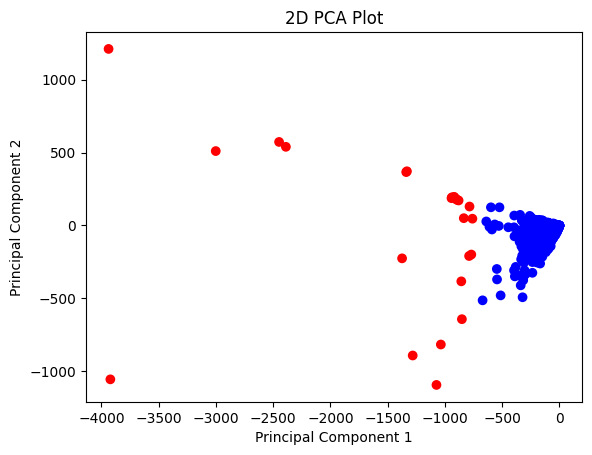

In [28]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Extract features from the "representation" column
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(clustered_df)
result = model.transform(clustered_df).select("pca_features")

# Extract the PCA features as numpy arrays
pca_data = result.rdd.map(lambda row: row.pca_features.toArray()).collect()

# Assign colors to clusters
color_mapping = {
    0: 'red',
    1: 'blue'
}

# Extract cluster predictions
predictions = clustered_df.select("prediction").collect()

# Map predictions to colors
colors = [color_mapping[prediction.prediction] for prediction in predictions]


# Plot the PCA results
x = [point[0] for point in pca_data]
y = [point[1] for point in pca_data]

plt.scatter(x, y, c=colors)
plt.title("2D PCA Plot")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


# 7. Aller plus loin

1. Pondérer les mots avec la formule Tf-Idf (avant KMeans)

In [29]:
from pyspark.ml.feature import CountVectorizer, IDF

# Configurer CountVectorizer
cv = CountVectorizer(inputCol="words", outputCol="raw_features", vocabSize=1000)

# Appliquer CountVectorizer pour obtenir les vecteurs de termes bruts
cv_model = cv.fit(tf_df)
raw_features_df = cv_model.transform(tf_df)

# Configurer IDF
idf = IDF(inputCol="raw_features", outputCol="tf_idf_features")

# Entraîner le modèle IDF
idf_model = idf.fit(raw_features_df)
tfidf_df = idf_model.transform(raw_features_df)

# Afficher le résultat
tfidf_df.select("tf_idf_features").show(n=1, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Normaliser les vecteurs représentant les documents (avant KMeans)

In [30]:
from pyspark.ml.feature import MinMaxScaler

# Créer un scaler
scaler = MinMaxScaler(inputCol="tf_idf_features", outputCol="scaled_features")

# Ajuster le scaler sur les données
scaler_model = scaler.fit(tfidf_df)

# Appliquer la transformation de normalisation
normalized_df = scaler_model.transform(tfidf_df)

# Afficher le résultat
normalized_df.select("scaled_features").show(n=1, truncate=False)
normalized_df = normalized_df.drop("features")


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

3. Appliquer KMeans

In [31]:
# Renommer la colonne "scaled_features" en "features"
normalized_df = normalized_df.withColumnRenamed("scaled_features", "features")

# Créer un modèle KMeans avec 2 clusters
kmeans = KMeans(k=2, seed=1)

# Entraîner le modèle KMeans avec les représentations vectorielles des documents
model = kmeans.fit(normalized_df)

# Attribuer des clusters aux documents
clustered_norm_df = model.transform(normalized_df)

# Afficher les résultats
clustered_norm_df.select("prediction").show(n=10)


+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         0|
|         0|
|         1|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 10 rows



In [32]:
clustered_norm_df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        organization|          newsgroups|                body|               words|        raw_features|     tf_idf_features|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Mantis Consultant...|alt.atheism,alt.a...|Archive-name: ath...|[archive-name:, a...|(1000,[0,1,2,3,4,...|(1000,[0,1,2,3,4,...|(1000,[0,1,2,3,4,...|         1|
|Mantis Consultant...|alt.atheism,alt.a...|Archive-name: ath...|[archive-name:, a...|(1000,[0,1,2,3,4,...|(1000,[0,1,2,3,4,...|(1000,[0,1,2,3,4,...|         1|
|Technical Univers...|         alt.atheism|In article <65974...|[in, article, <65...|(1000,[0,1,2,3,4,...|(1000,[0,1,2,3,4,...|(1000,[0,1,2,3,4,...|         1|
+--------------------+------------------

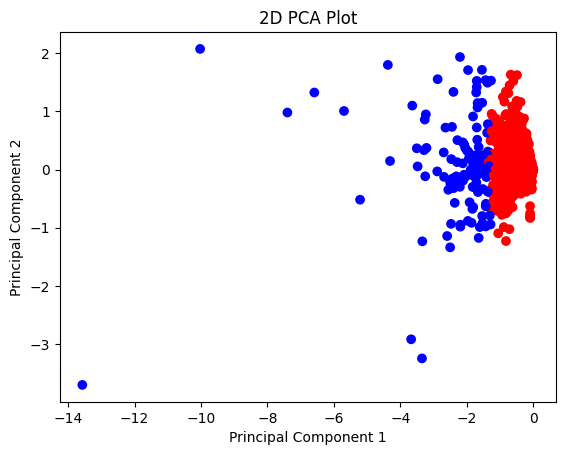

In [33]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Extract features from the "representation" column
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(clustered_norm_df)
result = model.transform(clustered_norm_df).select("pca_features")

# Extract the PCA features as numpy arrays
pca_data = result.rdd.map(lambda row: row.pca_features.toArray()).collect()

# Assign colors to clusters
color_mapping = {
    0: 'red',
    1: 'blue'
}

# Extract cluster predictions
predictions = clustered_norm_df.select("prediction").collect()

# Map predictions to colors
colors = [color_mapping[prediction.prediction] for prediction in predictions]


# Plot the PCA results
x = [point[0] for point in pca_data]
y = [point[1] for point in pca_data]

plt.scatter(x, y, c=colors)
plt.title("2D PCA Plot")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
